# Making Models Smaller via Knowledge Distillation

### A text classification example using Hugging Face Transformers and Amazon SageMaker

Welcome to our end-to-end example of _knowledge distillation_ using Hugging Face Transformers & Amazon SageMaker! This example is adapted from Chapter 8 of the O'Reilly book [_Natural Language Processing with Transformers_](https://transformersbook.com/).

Knowledge distillation is a general-purpose method for training a smaller student model to mimic the behavior of a slower, larger, but better-performing teacher. Originally introduced in 2006 in the context of ensemble models ([link](https://dl.acm.org/doi/10.1145/1150402.1150464)), it was later popularized in a famous [2015 paper](https://arxiv.org/abs/1503.02531) that generalized the method to deep neural networks and applied it to image classification and automatic speech recognition.

Given the trend toward pretraining language models with ever-increasing parameter counts (the largest at the time of writing having over one trillion parameters), knowledge distillation has also become a popular strategy to compress these huge models and make them more suitable for building practical applications.

In this notebook, we will use _intent detection_ as a case study (a form of text classification). This is an important component of text-based assistants, where low latencies are critical for maintaining a conversation in real time. We'll use the [CLINC150](https://huggingface.co/datasets/clinc_oos) dataset for training, and we've already fine-tuned a [RoBERTa-large model]((https://huggingface.co/optimum/roberta-large-finetuned-clinc) that will act as the teacher. Our goal will be to compress the knowledge of this teacher into a much smaller student called [MiniLM](https://huggingface.co/nreimers/MiniLMv2-L12-H384-distilled-from-RoBERTa-Large).

### Knowledge distillation for fine-tuning

So how is knowledge actually "distilled" or transferred from the teacher to the student during training? For supervised tasks like fine-tuning, the main idea is to augment the ground truth labels with a distribution of "soft probabilities" from the teacher which provide complementary information for the student to learn from. For example, if our teacher assigns high probabilities to multiple intents, then this could be a sign that these intents lie close to each other in the feature space. By training the student to mimic these probabilities, the goal is to distill some of this "dark knowledge" that the teacher has learned—that is, knowledge that is not available from the labels alone. 

Mathematically, the way this works is as follows. Suppose we feed an input sequence $x$ to the teacher to generate a vector of logits ${\bf z}(x)$ = $[z_1(x), \ldots , z_N(x)]$. We can convert these logits into probabilities by applying a softmax function:

$$\frac{\exp(z_i(x))}{\sum_j \exp(z_i(x))} \,$$

This isn't quite what we want, though, because in many cases the teacher will assign a high probability to one class, with all other class probabilities close to zero. When that happens, the teacher doesn't provide much additional information beyond the ground truth labels, so instead we "soften" the probabilities by scaling the logits with a temperature hyperparameter $T$ before applying the softmax:

$$ p_i(x) = \frac{\exp(z_i(x) / T)}{\sum_j \exp(z_i(x) / T)} \,$$

As shown in the figure below, higher values of $T$ produce a softer probability distribution over the classes and reveal much more information about the decision boundary that the teacher has learned for each training example. When $T=1$ we recover the original softmax distribution.

![kkd](./assets/soft-probs.png)

Since the student also produces softened probabilities $q_i(x)$ of its own, we can use the [Kullback–Leibler (KL)](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) divergence to measure the difference between the two probability distributions:

$$ D_{KL}(p, q) =  \sum_i p_i(x) \log \frac{p_i(x)}{q_i(x)} \,$$

With the KL divergence we can calculate how much is lost when we approximate the probability distribution of the teacher with the student. This allows us to define a knowledge distillation loss:

$$ L_{KD} = T^2 D_{KL} \,$$

where $T^2$ is a normalization factor to account for the fact that the magnitude of the gradients produced by soft labels scales as $1/T^2$. For classification tasks, the student loss is then a weighted average of the distillation loss with the usual cross-entropy loss $L_{CE}$ of the ground truth labels:

$$ L_\mathrm{student} = \alpha L_{CE} + (1-\alpha)  L_{KD} \,$$

where $\alpha$ is a hyperparameter that controls the relative strength of each loss. A diagram of the whole process is shown below; the temperature is set to 1 at inference time to recover the standard softmax probabilities.

![kkd](./assets/task-specific-kd.png)

### Knowledge distillation for pretraining

Knowledge distillation can also be used during pretraining to create a general-purpose student that can be subsequently fine-tuned on downstream tasks. In this case, the teacher is a pretrained language model like BERT, which transfers its knowledge about masked language modeling to the student. For example, in the [DistilBERT paper](https://arxiv.org/abs/1910.01108), the masked language modeling loss $L_{mlm}$ is augmented with a term from knowledge distillation and a cosine embedding loss $L_{cos} = 1 - \cos(h_s,h_t)$ to align the directions of the hidden state vectors between the teacher and student:

$$ L_\mathrm{DistilBERT}  = \alpha L_{mlm} + \beta L_{KD} + \gamma L_{cos}\,$$

In the literature, these two types of knowledge distillation are often called _task-specific_ (finetuning) and _task-agnostic_ (pretraining) knowledge distillation.

![knowledge-distillation](./assets/knowledge-distillation.png)
_Task-specific distillation (left) versus task-agnostic distillation (right). Figure from FastFormers by Y. Kim and H. Awadalla [arXiv:2010.13382]._

If you are more interested in those topics you should defintely read: 
* [DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter](https://arxiv.org/abs/1910.01108)
* [FastFormers: Highly Efficient Transformer Models for Natural Language Understanding](https://arxiv.org/abs/2010.13382)

Especially the [FastFormers paper](https://arxiv.org/abs/2010.13382) contains great research on what works and doesn't work when using knowledge distillation.

### Installation

In [1]:
%%capture
%pip install sagemaker huggingface_hub

This example will use the [Hugging Face Hub](https://huggingface.co/models) as remote model versioning service. To be able to push our model to the Hub, you need to register on the [Hugging Face](https://huggingface.co/join). 
If you already have an account you can skip this step. 
After you have an account, we will use the `notebook_login` util from the `huggingface_hub` package to log into our account and store our token (access key) on the disk. 

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /home/ec2-user/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


## Setup & Configuration

_If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

In [3]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::558105141721:role/sagemaker_execution_role
sagemaker bucket: sagemaker-us-east-1-558105141721
sagemaker session region: us-east-1


## `DistillationTrainer`


Normally, when fine-tuning a transformer model using PyTorch you should go with the `Trainer-API`. The [Trainer](https://huggingface.co/docs/transformers/v4.16.1/en/main_classes/trainer#transformers.Trainer) class provides an API for feature-complete training in PyTorch for most standard use cases. 

In our example we cannot use the `Trainer` out-of-the-box, since we need to pass in two models, the `Teacher` and the `Student` and compute the loss for both. But we can subclass the `Trainer` to create a `DistillationTrainer` which will take care of it and only overwrite the [compute_loss](https://github.com/huggingface/transformers/blob/c4ad38e5ac69e6d96116f39df789a2369dd33c21/src/transformers/trainer.py#L1962) method as well as the `init` method. In addition to this we also need to subclass the `TrainingArguments` to include the our distillation hyperparameters. 

The [DistillationTrainer](https://github.com/philschmid/knowledge-distillation-transformers-pytorch-sagemaker/blob/e8d04240d0ebbd7bd0741d196e8902a69a34b414/scripts/train.py#L28) and [DistillationTrainingArguments](https://github.com/philschmid/knowledge-distillation-transformers-pytorch-sagemaker/blob/e8d04240d0ebbd7bd0741d196e8902a69a34b414/scripts/train.py#L21) are directly integrated into [training script](./scripts/train.py)

```python
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature


class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher = teacher_model
        # place teacher on same device as student
        self._move_model_to_device(self.teacher, self.model.device)
        self.teacher.eval()

    def compute_loss(self, model, inputs, return_outputs=False):

        # compute student output
        outputs_student = model(**inputs)
        student_loss = outputs_student.loss
        # compute teacher output
        with torch.no_grad():
            outputs_teacher = self.teacher(**inputs)

        # assert size
        assert outputs_student.logits.size() == outputs_teacher.logits.size()

        # Soften probabilities and compute distillation loss
        loss_function = nn.KLDivLoss(reduction="batchmean")
        loss_logits = (
            loss_function(
                F.log_softmax(outputs_student.logits / self.args.temperature, dim=-1),
                F.softmax(outputs_teacher.logits / self.args.temperature, dim=-1),
            )
            * (self.args.temperature ** 2)
        )
        # Return weighted student loss
        loss = self.args.alpha * student_loss + (1.0 - self.args.alpha) * loss_logits
        return (loss, outputs_student) if return_outputs else loss
```



## Creating an Estimator with our Teacher & Student Model

In this example, we will use [RoBERTa-Large](https://huggingface.co/roberta-large) as Teacher and [MiniLM](https://huggingface.co/nreimers/MiniLMv2-L12-H384-distilled-from-RoBERTa-Large) as Student. Our Teacher is already fine-tuned on our dataset, which makes it easy for us to directly start the distillation training job rather than fine-tuning the teacher first to then distill it afterwards.
_**IMPORTANT**: This example will only work with a `Teacher` & `Student` combination where the Tokenizer is creating the same output._

Additionally, describes the [FastFormers: Highly Efficient Transformer Models for Natural Language Understanding](https://arxiv.org/abs/2010.13382) paper an additional phenomenon. 
> In our experiments, we have observed that dis-
tilled models do not work well when distilled to a
different model type. Therefore, we restricted our
setup to avoid distilling RoBERTa model to BERT
or vice versa. The major difference between the
two model groups is the input token (sub-word) em-
bedding. We think that different input embedding
spaces result in different output embedding spaces,
and knowledge transfer with different spaces does
not work well

In [4]:
from sagemaker.huggingface import HuggingFace
from huggingface_hub import HfFolder

# hyperparameters, which are passed into the training job
hyperparameters={
    'teacher_id':'optimum/roberta-large-finetuned-clinc',           
    'student_id':'nreimers/MiniLMv2-L12-H384-distilled-from-RoBERTa-Large',           
    'dataset_id':'clinc_oos',           
    'dataset_config':'plus',             
    'epochs': 10,             
    # distillation parameter
    'alpha': 0.055199695773231194, # 0.5,
    'temparature': 19, # 4 
    'learning_rate': 1e-4, # 3e-5
    # hpo parameter
    "run_hpo": False,
    "n_trials": 100,
    # push to hub config
    'push_to_hub': True,                            
    'hub_model_id': 'MiniLMv2-L12-H384-distilled-finetuned-clinc', 
    'hub_token': HfFolder.get_token()               
}

# create the Estimator
huggingface_estimator = HuggingFace(
    entry_point          = 'knowledge_distillation.py',        
    source_dir           = './scripts',       
    instance_type        = 'ml.p3.2xlarge',   
    instance_count       = 1,                 
    role                 = role,              
    transformers_version = '4.17',            
    pytorch_version      = '1.10',             
    py_version           = 'py38',            
    hyperparameters      = hyperparameters,   
)

## Start our Training with Knowledge-Distillation and Hyperparamter optimization  

In [5]:
# define a data input dictonary with our uploaded s3 uris

# starting the train job with our uploaded datasets as input
# setting wait to False to not expose the HF Token
huggingface_estimator.fit(wait=False)

Since we are using the Hugging Face Hub intergration with Tensorboard we can inspect our progress directly on the hub, as well as testing checkpoints during the training.

In [28]:
from huggingface_hub import HfApi

whoami = HfApi().whoami()
username = whoami['name']

print(f"https://huggingface.co/{username}/{hyperparameters['hub_model_id']}")

https://huggingface.co/philschmid/minilm-l12-h384-sst2-distilled


We were able to achieve a `accuracy` of 0.8337, which is a very good result for our model. Our distilled `Tiny-Bert` has 96% less parameters than the teacher `bert-base` and runs ~46.5x faster while preserving over 90% of BERT’s performances as measured on the SST2 dataset.

| model | Parameter | Speed-up | Accuracy |
|------------|-----------|----------|----------|
| BERT-base  | 109M      | 1x       | 93%      |
| tiny-BERT  | 4M        | 46.5x    | 83%      |

_Note: The [FastFormers paper](https://arxiv.org/abs/2010.13382) uncovered that the biggest boost in performance is observerd when having 6 or more layers in the student. The [google/bert_uncased_L-2_H-128_A-2](https://huggingface.co/google/bert_uncased_L-2_H-128_A-2) we used only had 2, which means when changing our student to, e.g. `distilbert-base-uncased` we should better performance in terms of accuracy._

## Deploying the endpoint

To deploy our endpoint, we call `deploy()` on our HuggingFace estimator object, passing in our desired number of instances and instance type.

In [ ]:
predictor = huggingface_estimator.deploy(1,"ml.c5.xlarge")

Then, we use the returned predictor object to call the endpoint. We will send 1000 sounds request with a sequence length of 128 to get a estimation of the latency.

In [31]:
sentiment_input= {"inputs": "Harry believes it, although no one else believes that Sally is innocent." * 9} # generates 128 seq length input

for i in range(1000):
  predictor.predict(sentiment_input)

We can now take a look at cloudwatch to get our monitoring metrics. 

In [35]:
print(f"https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#metricsV2:graph=~(metrics~(~(~'AWS*2fSageMaker~'ModelLatency~'EndpointName~'{predictor.endpoint_name}~'VariantName~'AllTraffic))~view~'timeSeries~stacked~false~region~'us-east-1~start~'-PT10M~end~'P0D~stat~'p99~period~300);query=~'*7bAWS*2fSageMaker*2cEndpointName*2cVariantName*7d*20{predictor.endpoint_name}")


https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#metricsV2:graph=~(metrics~(~(~'AWS*2fSageMaker~'ModelLatency~'EndpointName~'huggingface-pytorch-inference-2022-04-11-08-59-13-689~'VariantName~'AllTraffic))~view~'timeSeries~stacked~false~region~'us-east-1~start~'-PT10M~end~'P0D~stat~'p99~period~300);query=~'*7bAWS*2fSageMaker*2cEndpointName*2cVariantName*7d*20huggingface-pytorch-inference-2022-04-11-08-59-13-689


Finally, we delete the inference endpoint.

In [36]:
predictor.delete_model
predictor.delete_endpoint()

# Create Performance chart

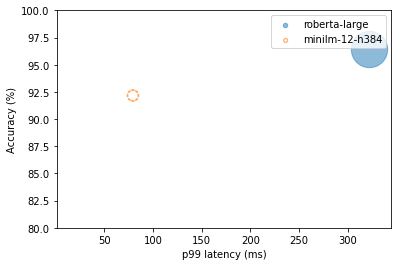

In [1]:
from visualize import plot_metrics
%matplotlib inline

metrics = {
  "roberta-large": {"time_p99_ms": 322, "accuracy": 0.9644,"size_mb":1322},
  "minilm-12-h384": {"time_p99_ms": 79, "accuracy": 0.9220,"size_mb":156},
  }

plot_metrics(metrics, "minilm-12-h384")